In [23]:
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
import pickle

warnings.filterwarnings("ignore")

# carga de datos

In [6]:
df = pd.read_csv("../data/raw/sales.csv")
df.head(), df.shape

(                         date      sales
 0  2022-09-03 17:10:08.079328  55.292157
 1  2022-09-04 17:10:08.079328  53.803211
 2  2022-09-05 17:10:08.079328  58.141693
 3  2022-09-06 17:10:08.079328  64.530899
 4  2022-09-07 17:10:08.079328  66.013633,
 (366, 2))

Convertir a serie temporal

In [ ]:
date_col = None
for c in df.columns:
    parsed = pd.to_datetime(df[c], errors="coerce")
    if parsed.notna().mean() > 0.8: 
        date_col = c
        df[c] = parsed
        break
if date_col is None:
    raise ValueError("No pude detectar columna de fecha. Indica cuál es la columna de fecha.")


In [8]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if not num_cols:
    raise ValueError("No hay columnas numéricas. Indica cuál es la columna de ventas.")
sales_col = num_cols[0]

In [9]:
ts = (df[[date_col, sales_col]]
      .dropna()
      .sort_values(date_col)
      .set_index(date_col)[sales_col])

ts.head(), ts.index.min(), ts.index.max()

(date
 2022-09-03 17:10:08.079328    55.292157
 2022-09-04 17:10:08.079328    53.803211
 2022-09-05 17:10:08.079328    58.141693
 2022-09-06 17:10:08.079328    64.530899
 2022-09-07 17:10:08.079328    66.013633
 Name: sales, dtype: float64,
 Timestamp('2022-09-03 17:10:08.079328'),
 Timestamp('2023-09-03 17:10:08.079328'))

# Paso 2: Construye y analiza la serie temporal

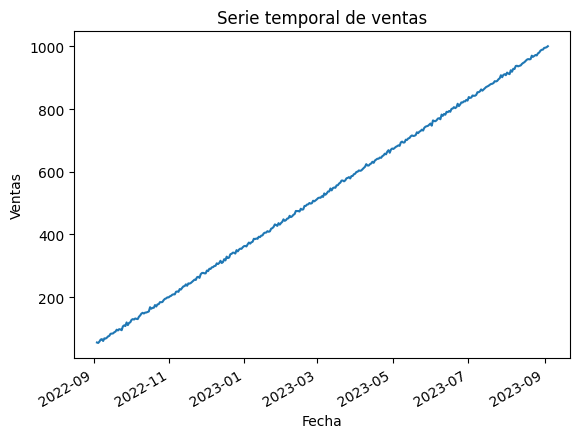

In [10]:
plt.figure()
ts.plot()
plt.title("Serie temporal de ventas")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.show()

Tensor

In [11]:
freq = pd.infer_freq(ts.index)
freq

'D'

REGULARIZAR FRECUENCIA

In [12]:
ts_reg = ts.asfreq(freq)
ts_reg = ts_reg.interpolate()
ts_reg.head()

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Freq: D, Name: sales, dtype: float64

DESCOMPOSICIÓN

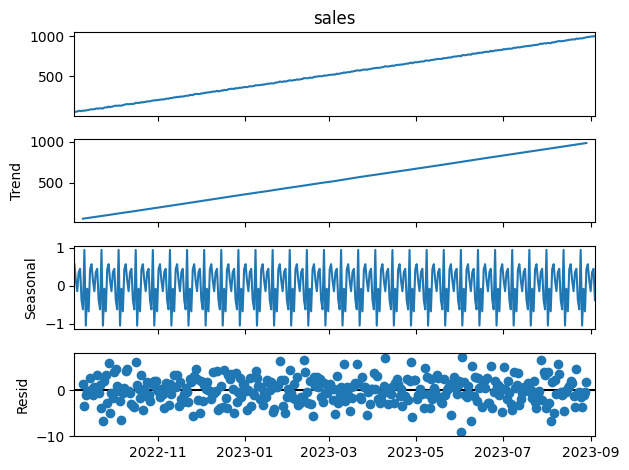

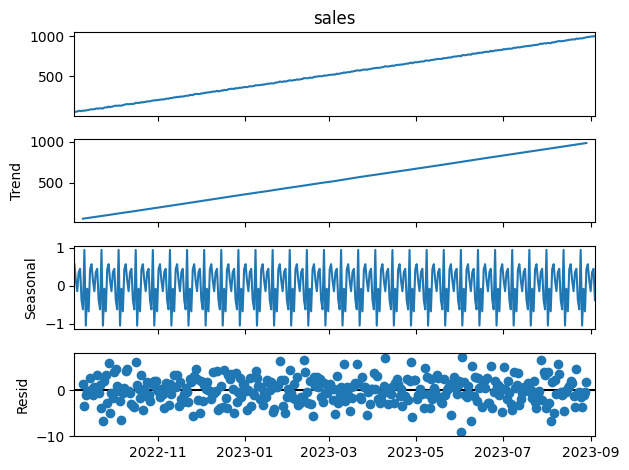

In [13]:
decomp = seasonal_decompose(ts_reg, model="additive", period=12)
decomp.plot()

ESTACIONARIEDAD

In [14]:
adf_result = adfuller(ts_reg.dropna())
adf_result

(np.float64(0.545414193706378),
 np.float64(0.9861899815311064),
 13,
 352,
 {'1%': np.float64(-3.4490648539347544),
  '5%': np.float64(-2.8697861692116478),
  '10%': np.float64(-2.5711631253228306)},
 np.float64(1764.0625918370981))

VARIABILIDAD

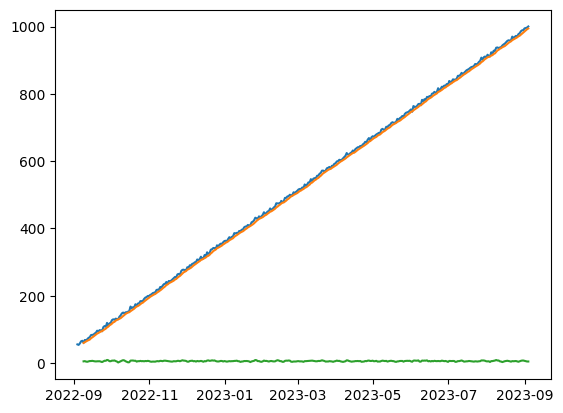

In [16]:
roll_mean = ts_reg.rolling(6).mean()
roll_std = ts_reg.rolling(6).std()

plt.figure()
plt.plot(ts_reg)
plt.plot(roll_mean)
plt.plot(roll_std)
plt.show()

# TRAIN / TEST

In [17]:
split = int(len(ts_reg) * 0.8)

train = ts_reg.iloc[:split]
test = ts_reg.iloc[split:]

train.shape, test.shape

((292,), (74,))

BUSCAR MEJOR ARIMA

In [18]:
best_aic = float("inf")
best_order = None
best_model = None

for p in range(0,4):
    for d in range(0,3):
        for q in range(0,4):
            try:
                model = ARIMA(train, order=(p,d,q))
                fitted = model.fit()
                if fitted.aic < best_aic:
                    best_aic = fitted.aic
                    best_order = (p,d,q)
                    best_model = fitted
            except:
                pass

best_order, best_aic

((0, 2, 3), np.float64(1482.3607777248235))

PREDICCIÓN

In [19]:
forecast = best_model.forecast(steps=len(test))
forecast

2023-06-22 17:10:08.079328    810.514364
2023-06-23 17:10:08.079328    812.935854
2023-06-24 17:10:08.079328    815.533696
2023-06-25 17:10:08.079328    818.131538
2023-06-26 17:10:08.079328    820.729380
                                 ...    
2023-08-30 17:10:08.079328    989.589107
2023-08-31 17:10:08.079328    992.186949
2023-09-01 17:10:08.079328    994.784790
2023-09-02 17:10:08.079328    997.382632
2023-09-03 17:10:08.079328    999.980474
Freq: D, Name: predicted_mean, Length: 74, dtype: float64

MÉTRICAS

In [20]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

safe_test = test.replace(0, np.nan)
mape = (np.abs((safe_test - forecast) / safe_test)).dropna().mean() * 100

mae, rmse, mape

(2.272629772940933,
 np.float64(2.82523758230765),
 np.float64(0.2529681058398799))

GRÁFICO FNIAL

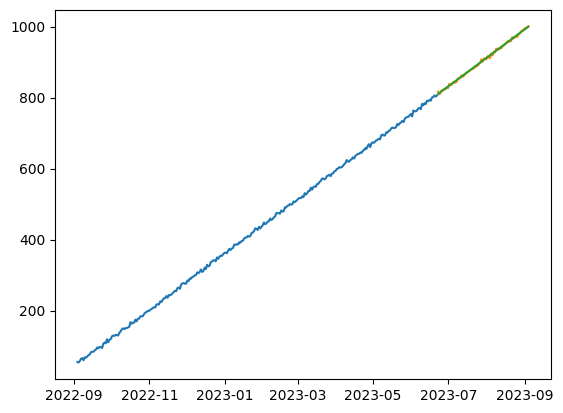

In [21]:
plt.figure()
plt.plot(train.index, train)
plt.plot(test.index, test)
plt.plot(test.index, forecast)
plt.show()

GUARDAR MODELO

In [24]:
with open("../models/arima_sales_model.pkl", "wb") as f:
    pickle.dump(best_model, f)